## 0. Importing libraries

In [25]:
import re
import html
import string
import pandas as pd
import numpy as np
from stackapi import StackAPI
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mp
mpl.rcParams["xtick.labelsize"] = 16
mpl.rcParams["ytick.labelsize"] = 16
mpl.rcParams["axes.labelsize"] = 18

## 1. Custom functions created

In [4]:
def create_dataframe(data, name):
    
    '''
    Function that creates a CSV file from the dictionary data object returned by the API.
    
    Input 
           : data -> data from API -> type : dictionary
           : name -> name of the CSV file -> type : string
    
    Output : Returns nothing
    '''
    
    # Extracting the "items" values from the dictionary data storing into data_items
    data_items = data["items"]
    
    # Creating an empty dataframe
    data_frame = pd.DataFrame()
    
    # Creating empty lists for questions as well as for tags of the questions
    question_list = []
    tags_list = []

    # Looping through data items
    for i in data_items:
        
        # Extracting title from the iterator i of data items, appending it to question_list
        question_list.append(i["title"])
        
        # Extracting tags from the iterator i of data items
        # Formating the tags for e.g "__label__TAG1 __label__TAG2" (Required by fasttext)
        # Appending it to tags_list
        tags_list.append("".join(["__label__" + str(i) + " " for i in i["tags"]]))
    
    # Creating a column named "Question" using question_list
    data_frame["Question"] = question_list
    
    # Creating a column named "Labels" using tags_list
    data_frame["Labels"] = tags_list
    
    # Saving the data_frame to csv file
    data_frame.to_csv(name + ".csv", header = True)
    
def dataframe_to_text(df, clean):
    
    '''
    Function that creates a text file from the pandas dataframe.
    
    Input  
           : df -> type : pandas dataframe
           : clean -> whether to clean data or not -> type : boolean
            
    Output : Returns nothing
    '''
    
    # Creating an empty string
    final_string = ""
    
    filename = "final_data.txt"
    
    if clean:
        filename = "final_data_processed.txt"
    
    # Opening(Creating if not exist) a text file named "final_data" in writing mode with encoding utf-8
    with open(filename, 'w', encoding = 'utf-8') as file:
        
        # Iterating through df(dataframe) rows
        for index, row in df.iterrows():
            
            # Storing the question
            question = row["Question"]
            
            if clean:
                # When data is gathered from APIs there are generally HTML escape characters in the data
                # Using html.unenscape() to convert HTML escape characters into string in lowercase
                question = html.unescape(question).lower()

                # Cleaning Latex formulas
                question = re.sub(r'\$[\s\S]*\$',"", question).strip()

                # Keeping the '-' because it is used to join words for example part-time
                question = re.sub(r'[^A-Za-z0-9\-\s]+', "", question).strip()
            
            # Appending labels(lowercase) and question to string
            final_string += (row["Labels"] + question)
            
            # Appending new line
            final_string += '\n'
        
        # Writing the entire string to file
        file.write(final_string.strip())

## 2. Data Generation

### 2.1 Setting parameters for API call

In [8]:
# For Authentication (OAuth call)
c_key = "qiEDB0WIq3e3MM7LRZB*3Q(("
c_secret = "L7Pv1pOb2VJxDvBy9qH38A((" 

# Configuring the APIs
## INFORMATION SECURITY
SITE_IS = StackAPI('security', key = c_key, client_secret = c_secret)

## STATISTICS
SITE_ST = StackAPI('stats', key = c_key, client_secret = c_secret)

## PHYSICS
SITE_PH = StackAPI('physics', key = c_key, client_secret = c_secret)

# TOTAL QUESTION = page_sizes * max_pages = 50,000
## INFORMATION SECURITY
SITE_IS.page_sizes = 100
SITE_IS.max_pages = 500

## STATISTICS
SITE_ST.page_sizes = 100
SITE_ST.max_pages = 500

## PHYSICS
SITE_PH.page_sizes = 100
SITE_PH.max_pages = 500

### 2.2 Calling the API

In [4]:
# Questions for INFORMATION SECURITY
data_IS = SITE_IS.fetch("questions")

# Questions for STATISTICS
data_ST = SITE_ST.fetch("questions")

# Questions for PHYSICS
data_PH = SITE_PH.fetch("questions")

### 2.3 Creating dataframe from the object returned by StackAPI

In [12]:
# For more information about the function "create_dataframe" go to section 1. Custom Functions Created
create_dataframe(data_IS, "IS")
create_dataframe(data_ST, "STATS")
create_dataframe(data_PH, "PHYSICS")

### 2.4 Merging all the dataframes

In [80]:
# Reading data from csv files
df_IS = pd.read_csv("IS.csv", index_col = 0)
df_ST = pd.read_csv("STATS.csv", index_col = 0)
df_PH = pd.read_csv("PHYSICS.csv", index_col = 0)

# Concatinating them into one big dataframe
df_list = [df_IS, df_PH, df_ST]
df_final = pd.concat(df_list)

# Shuffling the rows for randomness
df_final = shuffle(df_final, random_state = 123)

# Removing the index column created by shuffle function 
df_final.reset_index(drop = True, inplace = True)

# Saving the dataframe to csv file
df_final.to_csv("final.csv", header = True)

### 2.5 Dataframe to Text file (Required by fasttext)

In [81]:
# Reading a csv file
df_final = pd.read_csv("final.csv")

# Creating a text file from dataframe and also cleaning the data
# For more information about the function "dataframe_to_text" go to section 1. Custom Functions Created

# WITHOUT CLEANING
dataframe_to_text(df = df_final, clean = False)

# WITH CLEANING
dataframe_to_text(df = df_final, clean = True)

### 2.6 Creating Train(70%), Validation(20%) and Test(10%) Splits

Training = 150,000 * 0.70 = 105000 observations

Validation = 150,000 * 0.20 = 30000 observations

Testing = 150,000 * 0.10 = 15000 observations

#### 2.6.1 Without cleaning

In [82]:
%%bash
head -n 105000 final_data.txt > data.train
tail -n 15000 final_data.txt > data.test
tail -n 45000 final_data.txt | head -n 30000 > data.valid

#### 2.6.2 With cleaning

In [83]:
%%bash
head -n 105000 final_data_processed.txt > data_processed.train
tail -n 15000 final_data_processed.txt > data_processed.test
tail -n 45000 final_data_processed.txt | head -n 30000 > data_processed.valid

### 2.7 Creating Cleaned CSV

#### 2.7.1 Creating data

In [12]:
cleaned_file = open("final_data_processed.txt", "r")

questions = []
tags = []

for i in cleaned_file:
    list_string = i.split()
    count = i.count("label")
    tags.append(" ".join(list_string[:count]))
    questions.append(" ".join(list_string[count:]))

cleaned_dataframe = pd.DataFrame({"Question" : questions, "Labels" : tags})

#cleaned_dataframe.to_csv("final_cleaned.csv", header = True)

#### 2.7.2 Plots

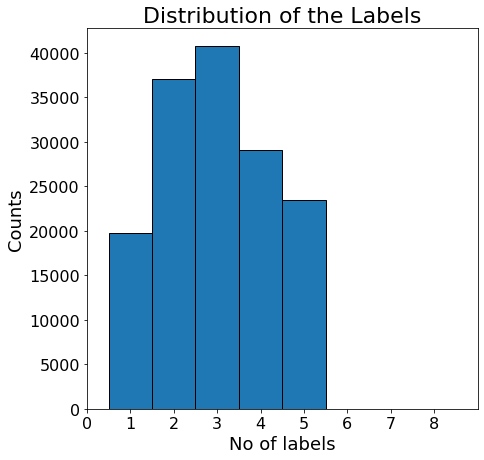

In [28]:
counts = []

for i in cleaned_dataframe["Labels"]:
    counts.append(i.count("label"))

plt.figure(figsize = (7,7))
bins = np.arange(10) - 0.5
plt.hist(counts, bins = bins, edgecolor = "black")
plt.xticks(range(9))
plt.xlim([0, 9])
plt.title("Distribution of the Labels", fontsize = 22)
plt.xlabel("No of labels")
plt.ylabel("Counts")
plt.show()

In [3]:
is_df = pd.read_csv("IS.csv")

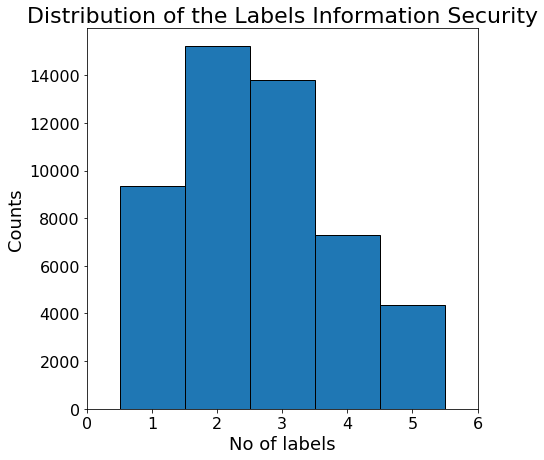

In [47]:
counts = []

for i in is_df["Labels"]:
    counts.append(i.count("label"))

plt.figure(figsize = (7,7))
bins = np.arange(10) - 0.5
plt.hist(counts, bins = bins, edgecolor = "black")
plt.xticks(range(66))
plt.xlim([0, 6])
plt.title("Distribution of the Labels Information Security", fontsize = 22)
plt.xlabel("No of labels")
plt.ylabel("Counts")
plt.show()

In [ ]:
phy_df = pd.read_csv("PHYSICS.csv")

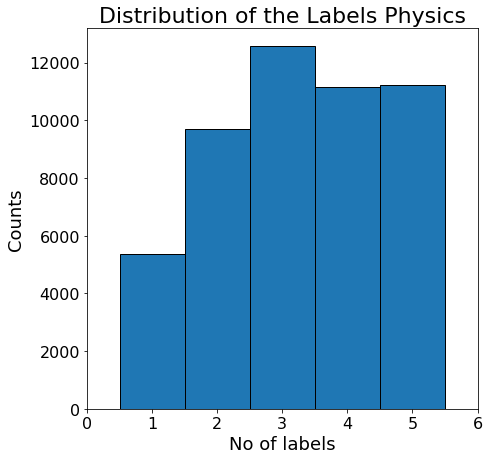

In [46]:
counts = []

for i in phy_df["Labels"]:
    counts.append(i.count("label"))

plt.figure(figsize = (7,7))
bins = np.arange(10) - 0.5
plt.hist(counts, bins = bins, edgecolor = "black")
plt.xticks(range(66))
plt.xlim([0, 6])
plt.title("Distribution of the Labels Physics", fontsize = 22)
plt.xlabel("No of labels")
plt.ylabel("Counts")
plt.show()

In [ ]:
stat_df = pd.read_csv("STATS.csv")

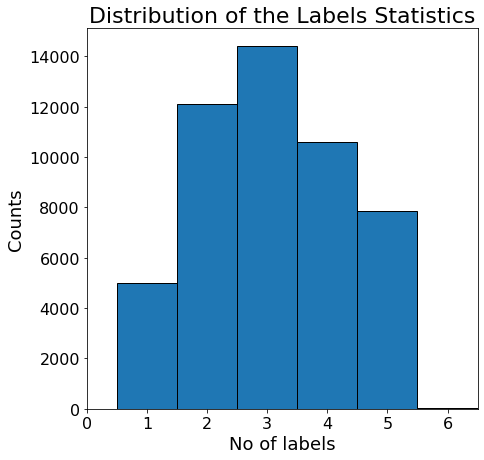

In [48]:
counts = []

for i in stat_df["Labels"]:
    counts.append(i.count("label"))

plt.figure(figsize = (7,7))
bins = np.arange(10) - 0.5
plt.hist(counts, bins = bins, edgecolor = "black")
plt.xticks(range(66))
plt.xlim([0, 6.5])
plt.title("Distribution of the Labels Statistics", fontsize = 22)
plt.xlabel("No of labels")
plt.ylabel("Counts")
plt.show()